In [4]:
import numpy as np
import scipy.stats.qmc as qmc
import matplotlib.pyplot as plt
import numpy.random as random

import scipy as sp
import scipy.integrate as integrate

from tqdm import tqdm 

GENERATOR = np.random.default_rng(seed=None)

# Exericse sheet 8

## Exercise 4 (Two simple QMC test problems)

In [5]:
### FINITE ELEMENT STUFF

def kappa(
    x: float,  # Evaluation point
    q: float,
    omegas: np.array,
) -> float:
    kappa = np.zeros(len(x))
    for j in range(1, len(omegas) + 1):
        # Compute corresponding basis function.
        a = (1 / j ** q) * np.sin(2 * j * np.pi * x)
        kappa += omegas[j - 1] * a
    
    return np.exp(kappa)

def create_stiffness_matrix(
    N: int,
    q: float,
    omegas: np.array,
):
    h = 1 / (N - 1)
    diagonals = [np.empty((N - 1)), np.empty((N)), np.empty((N - 1))]
    TRAPEZ_POINTS = 21
    for i in range(len(diagonals[1])):
        #diagonals[1][i] = 1/(h**2) * integrate.quad(lambda x: kappa(x, q, omegas), h*(i-1), h*(i+1))[0]
        x = np.linspace(h*(i-1), h*(i+1),TRAPEZ_POINTS)
        y = kappa(x, q,  omegas)
        diagonals[1][i]  =    np.trapz(y, x)
    for i in range(len(diagonals[0])):
        #diagonals[0][i] = -1/(h**2) * integrate.quad(lambda x: kappa(x, q, omegas), h*(i), h*(i+1))[0]
       
        x = np.linspace( h*(i), h*(i+1),TRAPEZ_POINTS)
        y = kappa(x, q, omegas)
        diagonals[0][i]  =    np.trapz(y, x)

        diagonals[2][i] = diagonals[0][i]
    # Impose boundary conditions.
    diagonals[0][0] = 0
    diagonals[2][0] = 0
    diagonals[0][-1] = 0
    diagonals[2][-1] = 0
    
    mat = sp.sparse.diags(diagonals, [-1, 0, 1])

    return mat


def create_rhs(N: int, f):
    h = 1 / (N - 1)
    TRAPEZ_POINTS = 21
    vec = np.empty((N))

    for i in range(len(vec)):
        #vec[i] = integrate.quad(lambda x: f(x)*(1-abs(h*i-x)/h), h*(i-1), h*(i+1))[0]
        x = np.linspace(h*(i-1), h*(i+1),TRAPEZ_POINTS)
        y = f(x)*(1-abs(h*i-x)/h)
        vec[i] =    np.trapz(y, x)
    # Impose boundary conditions.
    vec[0] = 0
    vec[-1] = 0

    return vec



In [6]:
###GENERATING VECTORS FOR LATTICE RULE

def generating_vectors(s, N=None):
    # Source: https://wsc.project.cwi.nl/woudschoten-conferences/2016-woudschoten-conference/FKtalk1.pdf, Slide 14
    if s==2:
        return np.array([1, 19])
    if s==10:# Source: https://people.cs.kuleuven.be/~dirk.nuyens/qmc-generators/LATSEQ/exew_base2_m20_a3_HKKN.txt
        return np.array([1, 364981, 245389, 97823, 488939, 62609, 400749, 385317, 21281, 223487])
    else:
        return generate_custom_vectors(N,s)

def generate_custom_vectors(N,s):
    
    def B_2(x):
        return np.power(x,2)-x + (1/6)
    
    U_N = np.gcd(np.arange(0,N), N)
    U_N = np.arange(N)[U_N==1]
    z = np.empty(s)
    p = np.ones(N)
    #print("U_N",U_N)
     
    G_N = B_2(np.modf(np.outer(U_N,np.arange(N))/N )[0])
    #print("G_N",G_N )
    #print("GN SHAPE",G_N.shape)
    #print("sum",np.sum(G_N,axis=0))
    #print("sum SHAPE",np.sum(G_N,axis=0).shape)
    z[0]=1
      
    for i in range(1,s):
        #print("p:",p)
        delta = (1/N)*np.inner(G_N,p )
        #print("delta",delta.shape)
        #print("argmin delta",np.argmin(delta))
        z[i]= U_N[np.argmin(delta)]
        p = np.multiply((np.ones(N) + G_N[i]),p)
    return z

#generate_custom_vectors(64,2)

In [7]:
## LATTICE POINTS

def generate_lattice_points(
    z,  # generating vector
    m,  # 2 ** m number of points
    shift = False,
    previous_lattice=np.array([]),  # reuse points from previous lattice
    
):
    def shift_points(s: int, points: np.array):
        shift_vector = np.random.uniform(0, 1, s)
        
        return np.modf(points + shift_vector)[0]
    
    def generate(index):
        return np.modf(
            np.reshape(index, (-1, 1)) * z / N
        )[0]

    # Set number of points.
    N = 2 ** m
    
    rows = np.arange(0, N, 1)

    if previous_lattice.size == 0:
        # Generate first lattice.
        new_lattice = generate(rows)
    else:
        new_lattice = np.empty([N, z.size])
        
        even_rows = rows[rows % 2 == 0]
        odd_rows = rows[rows % 2 == 1]
        
        new_lattice[even_rows] = previous_lattice
        new_lattice[odd_rows] = generate(odd_rows)
    
    if shift:
        new_lattice = shift_points(len(z),new_lattice)
    
    return new_lattice -0.5



In [8]:
### SOBOL POINTS

def generate_sobol_points(
    s: int,
    m: int,
    scramble=True,
    generator=None
):
    sampler = qmc.Sobol(d=s, scramble=scramble,seed=generator.integers(10**8))
    return sampler.random_base2(m=m) - 0.5

In [11]:
### MONTE CARLO

def MC(s,q,N_samples,h,sample_Var=False):
     
    N = int(1/h) +1 
    MC_samples = np.empty(N_samples)
     
    
    f = create_rhs(N, lambda x: 1)                    
    for j in tqdm(range(N_samples)):
        omegas = random.uniform(-0.5,0.5,s)
        mat = create_stiffness_matrix(N, q, omegas)

        u = sp.sparse.linalg.spsolve(mat, f)
        MC_samples[j] = u[int((N - 1) * 0.7)]
    MC_mean  = np.mean(MC_samples)

    if sample_Var:
        MC_var  = np.var(MC_samples,ddof=1)                  
        return MC_mean,MC_var
    else:
        return MC_mean
    

In [12]:
## QUASI-MONTE CARLO

def QMC(s,q,m,h,R,sobol=True,sample_Var=False):
 

 
    N_samples = 2**m
    MC_mean = np.empty(shape=R)
    MC_var= np.empty(shape=R)
    for i in tqdm(range(R)):
        
        if sobol:
            points=generate_sobol_points(s,m,scramble=True,generator=GENERATOR)
        else:
            z = generating_vectors(s, N=2**m)
            points =generate_lattice_points(z,m,True)


        
        MC_samples = np.empty(N_samples)
        
        N = int(1/h) +1 
        
        f = create_rhs(N, lambda x: 1)                    
        for j in range(N_samples):
            omegas =  points[j]
            mat = create_stiffness_matrix(N, q, omegas)

            u = sp.sparse.linalg.spsolve(mat, f)
            MC_samples[j] = u[int((N - 1) * 0.7)]
        MC_mean[i] = np.mean(MC_samples)
        if sample_Var:
            MC_var[i]  = np.var(MC_samples,ddof=1)
                
    if sample_Var:    
        return np.mean(MC_mean),np.mean(MC_var)
    else:
        return np.mean(MC_mean)


a) TESTING THE FUNCTIONS

In [13]:
R=8
m=10
N_samples=(2**m) * R
MC_res,MC_svar = MC(s=10,q=2,N_samples=N_samples,h=0.05,sample_Var=True)
lattice_res,lattice_svar = QMC(s=10,q=2,m=m,R=R,h=0.05,sobol=False,sample_Var=True)
sobol_res,sobol_svar = QMC(s=10,q=2,m=m,R=R,h=0.05,sobol=True,sample_Var=True)


  0%|          | 0/8192 [00:00<?, ?it/s]C:\Users\Aaron Maekel\AppData\Local\Temp\ipykernel_7084\4031945572.py:14: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = sp.sparse.linalg.spsolve(mat, f)
  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\Aaron Maekel\AppData\Local\Temp\ipykernel_7084\3147889133.py:29: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = sp.sparse.linalg.spsolve(mat, f)
100%|██████████| 8/8 [00:22<00:00,  2.82s/it]


In [16]:
print("MC ESTIMATOR:                   ",MC_res," SAMPLE VARIANCE: ",MC_svar)
print("QMC ESTIMATOR with lattice rule:",lattice_res," SAMPLE VARIANCE: ",lattice_svar)
print("QMC ESTIMATOR with sobol rule:  ",sobol_res," SAMPLE VARIANCE: ",sobol_svar)

MC ESTIMATOR:                    0.010953589642425064  SAMPLE VARIANCE:  0.0052880905544996255
QMC ESTIMATOR with lattice rule: 0.010459284869291666  SAMPLE VARIANCE:  0.005345585363143194
QMC ESTIMATOR with sobol rule:   0.010469506352836546  SAMPLE VARIANCE:  0.005351991767562446


b) ERROR OF CONVERGENCE RATE

In [ ]:
R=8
mmesh =np.arange(10,20)
q=2
N_samples=(2**m) * R
MC_res = np.empty(len(mmesh))
MC_svar  = np.empty(len(mmesh))
lattice_res = np.empty(len(mmesh))
lattice_svar = np.empty(len(mmesh))
sobol_res = np.empty(len(mmesh))
sobol_svar = np.empty(len(mmesh))
i=0
for m in mmesh:

    MC_res[i], MC_svar[i] = MC(s=10,q=q,N_samples=N_samples,h=0.05,sample_Var=True)
    lattice_res[i],lattice_svar[i] = QMC(s=10,q=q,m=m,R=R,h=0.05,sobol=False,sample_Var=True)
    sobol_res[i],sobol_svar[i] = QMC(s=10,q=q,m=m,R=R,h=0.05,sobol=True,sample_Var=True)
    i+=1

  0%|          | 0/8192 [00:00<?, ?it/s]C:\Users\Aaron Maekel\AppData\Local\Temp\ipykernel_7084\4031945572.py:14: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = sp.sparse.linalg.spsolve(mat, f)
  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\Aaron Maekel\AppData\Local\Temp\ipykernel_7084\3147889133.py:29: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = sp.sparse.linalg.spsolve(mat, f)
 12%|█▎        | 1/8 [00:11<01:18, 11.16s/it]

In [17]:
import matplotlib.pyplot as plt
 

 
 
# Plot the curves
plt.figure(figsize=(8, 6))
plt.plot(R, lattice_sample_var, label="lattice rule", color='blue')
plt.plot(R,sobol_sample_var, label="sobol rule", color='red')
#plt.plot(R, y3, label="tan(x)", color='green')



# Adding labels and title
plt.xlabel("R")
plt.ylabel("Sample Var")
plt.title("Three Different Sample variances depending on amount of realizations R:  ")

# Show legend
plt.legend()

# Display the plot
plt.yscale("log")
plt.grid(True)
plt.show()


NameError: name 'lattice_sample_var' is not defined

<Figure size 800x600 with 0 Axes>

USING DIFFERENT NUMBERS OF POINTS, ALSO COMPARING IT WITH MC:

In [115]:
def MC_integrate(
    fun, #chosen function
    N,  # number of points
    s,  # dimension
     
):
    xs = np.random.uniform(0,1,(N,s))
    return  fun(s, xs)

In [ ]:
s=10
R=32

mmesh = np.arange(10,21)
print(mmesh)
sobol_est = np.empty(len(mmesh))
sobol_sample_var = np.empty(len(mmesh)) 
lattice_est = np.empty(len(mmesh))
lattice_sample_var = np.empty(len(mmesh)) 

MC_est = np.empty(len(mmesh)) 
MC_sample_var =  np.empty(len(mmesh)) 
i=0
for m in mmesh:
    
    z = generating_vectors(s)
    points = generate_lattice_points(z, m)

    MCs=   MC_integrate(g, 2**m*R,s)
    MC_est[i] = np.mean(MCs)
    MC_sample_var[i] =  np.var(MCs,ddof=1)
    
    
    sobol_estimates = []
    lattice_estimates = []
    for _ in range(R):
        scrambled_points = generate_sobol_points(s, int(m), scramble=True)
        sobol_estimates.append(
            np.mean(g(s, scrambled_points))
        )
        shifted_points = shift_points(s, points)
        lattice_estimates.append(
            np.mean(g(s, shifted_points))
        )
        
    sobol_est[i] = np.mean(np.array(sobol_estimates))
    sobol_sample_var[i] = np.var(sobol_estimates,ddof=1)
    lattice_est[i] = np.mean(np.array(lattice_estimates))
    lattice_sample_var[i] = np.var(lattice_estimates,ddof=1)
    i+=1
print(sobol_sample_var)
print(lattice_sample_var)
print(MC_est)
print(MC_sample_var)

[10 11 12 13 14 15 16 17 18 19 20]
[5.20014520e-14 8.50432463e-12 4.73497866e-17 1.07355063e-32
 7.10542736e-15 1.94829558e-32 5.64608108e-32 1.74948991e-32
 5.56655881e-33 9.42338884e-32 1.94829558e-32]
[8.92682504e-08 9.73321649e-08 8.97213939e-08 8.74922421e-08
 9.33803370e-08 1.10324462e-07 5.85632655e-08 1.05237005e-07
 1.02419842e-07 1.16855306e-07 8.47051143e-08]
[0.99924399 1.00067689 0.99805051 1.00005737 0.99967701 1.00013773
 1.00009321 1.00022504 0.99985314 1.000048   0.99999016]
[0.08958007 0.08978178 0.08998511 0.09016992 0.08986143 0.09017887
 0.09012418 0.09020326 0.09018512 0.09016346 0.0901705 ]


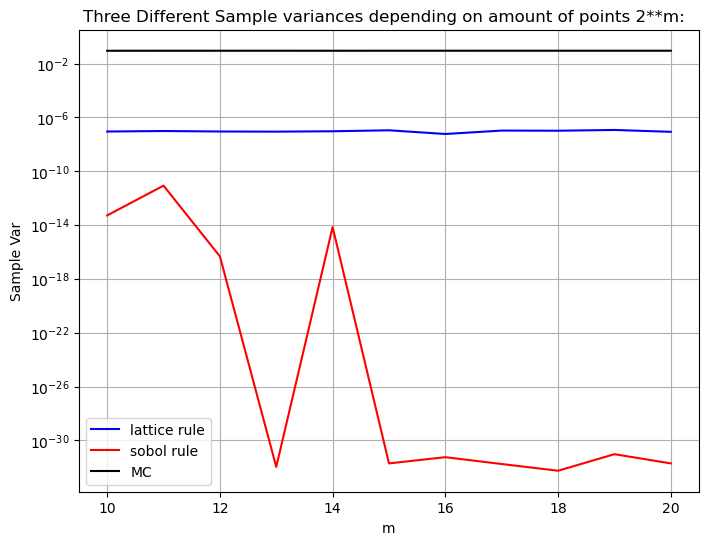

In [ ]:
import matplotlib.pyplot as plt
 

 
 
# Plot the curves
plt.figure(figsize=(8, 6))
plt.plot(mmesh, lattice_sample_var, label="lattice rule", color='blue')
plt.plot(mmesh,sobol_sample_var, label="sobol rule", color='red')
plt.plot(mmesh,MC_sample_var, label="MC", color='black')
#plt.plot(R, y3, label="tan(x)", color='green')



# Adding labels and title
plt.xlabel("m")
plt.ylabel("Sample Var")
plt.title("(s=10) Three Different Sample variances depending on amount of points 2**m:  ")

# Show legend
plt.legend()

# Display the plot
plt.yscale("log")
plt.grid(True)
plt.show()


COMPARING LOW VS HIGH DIMENSIONALITY, (FIXED AMOUNT OF POINTS)

In [207]:
smesh= np.arange(2,10)
R=32
m=10
 

sobol_est = np.empty(len(smesh))
sobol_sample_var = np.empty(len(smesh)) 
lattice_est = np.empty(len(smesh))
lattice_sample_var = np.empty(len(smesh)) 

MC_est = np.empty(len(smesh)) 
MC_sample_var =  np.empty(len(smesh)) 
i=0
for s in smesh:
    #generate new points for lattice rule
    z = generating_vectors(s,2**m)
    points = generate_lattice_points(z, m)

    MCs=   MC_integrate(g, 2**m*R,s)
    MC_est[i] = np.mean(MCs)
    MC_sample_var[i] =  np.var(MCs,ddof=1)
    
    
    sobol_estimates = []
    lattice_estimates = []
    for _ in range(R):
        scrambled_points = generate_sobol_points(s, int(m), scramble=True)
        sobol_estimates.append(
            np.mean(g(s, scrambled_points))
        )
        shifted_points = shift_points(s, points)
        lattice_estimates.append(
            np.mean(g(s, shifted_points))
        )
        
    sobol_est[i] = np.mean(np.array(sobol_estimates))
    sobol_sample_var[i] = np.var(sobol_estimates,ddof=1)
    lattice_est[i] = np.mean(np.array(lattice_estimates))
    lattice_sample_var[i] = np.var(lattice_estimates,ddof=1)
    i+=1
print(sobol_sample_var)
print(lattice_sample_var)
print(MC_sample_var)

[1.86264515e-09 1.98805672e-33 2.12757388e-12 1.86304048e-09
 1.86264507e-09 1.17958449e-10 1.81516429e-18 2.91503044e-11]
[7.22388554e-08 7.39547635e-08 9.14355713e-08 6.74891229e-08
 9.21797233e-08 8.73113436e-08 5.07458500e-08 7.61903377e-08]
[0.08919408 0.08941684 0.09013465 0.09003096 0.09056535 0.08939441
 0.08991001 0.09050992]


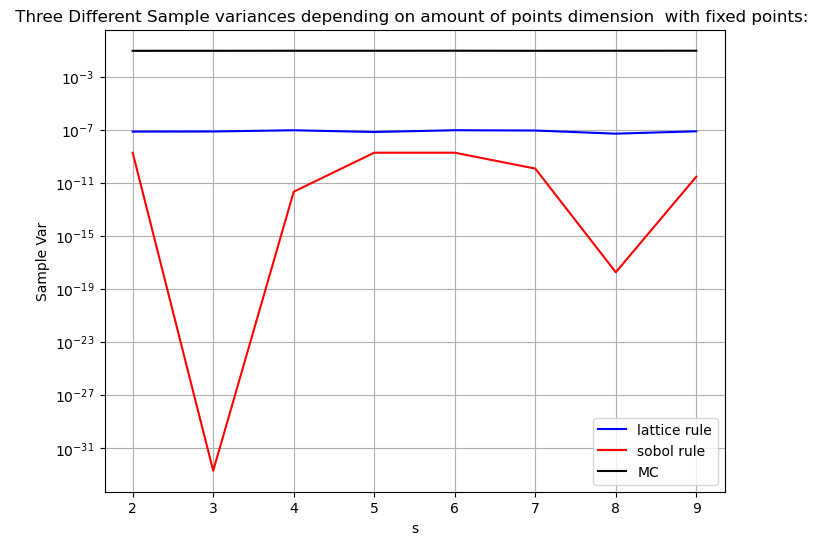

In [208]:
import matplotlib.pyplot as plt
 

 
 
# Plot the curves
plt.figure(figsize=(8, 6))
plt.plot(smesh, lattice_sample_var, label="lattice rule", color='blue')
plt.plot(smesh,sobol_sample_var, label="sobol rule", color='red')
plt.plot(smesh,MC_sample_var, label="MC", color='black')
#plt.plot(R, y3, label="tan(x)", color='green')



# Adding labels and title
plt.xlabel("s")
plt.ylabel("Sample Var")
plt.title(" Three Different Sample variances depending on amount of points dimension  with fixed points:  ")

# Show legend
plt.legend()

# Display the plot
plt.yscale("log")
plt.grid(True)
plt.show()
